In [1]:
import numpy as np
import tensorflow as tf
import deepxde as dde

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [2]:

"""
Constant declaration

"""
#Constant  τ
tao = 1

#Constant Δt
delta_t = 0.1

#Constant L
L = 10

#Constant M
M = 8 * 4.4492

In [3]:
def miu_L(l):
    return (l * np.pi) / (2 * M)

def miu_S(s):
    return (s * np.pi) / (2 * M)

def F(position = 0):
    temp = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    return temp[position]

def N(position = 0):
    temp = [i for i in range(2, 21)]
    return temp[position]

def a_LS(l, s):
    if l == s:
        return 0
    else:
        return ((-1) ** (l + s) - 1) * ((miu_L(l) - miu_S(s)) ** (-2) - (miu_L(l) + miu_S(s)) ** (-2)) / (2 * M)

def b_LS(l, s, F_position = 0):
    if l == s:
        return 0
    else:
        return (F(F_position) / M) * (1 - (-1) ** (l + s)) * (miu_L(l) * miu_S(s)) / ((miu_L(l)) ** 2 - (miu_S(s)) ** 2)

def delta_LS(l, s):
    if l == s:
        return 1
    else:
        return 0


In [4]:
"""
This function is for the import of the data, an extend name of ".csv" is required
The data here is not for the backpropagation of the neural network, it is for the obtaining the numerical solution of PDE and for further 
analysis
@para abs_loc: The absolute location of the data file(.csv file required). eg: C\\User\\Desktop\\data.csv
@return X is the original data to get the numerical solution of PDE, Y here can be treated as "true value"
"""
def import_data(abs_loc):
    original_data = np.load(abs_loc)
    t_import, x_import, exact = original_data["t"], original_data["x"], original_data["usol"].T
    x_data, t_data = np.meshgrid(x, t)
    X = np.vstack((np.ravel(x_data), np.ravel(t_data))).T
    Y = exact.flatten()[:, None]
    return X, Y

In [5]:
"""
Declaration of PDE which is defined as:
            ∂f^l/∂t + Conv[f^]l = Scat[f^]l
where:
            fl = f(x, t)
which is time-dependent
"""
def PDE(independt_vars, y):
    #Prepare the list to store the result of ∂f/∂x, ∂fl/∂t, Conv[f]l and Scat[f]l. Here takes N = 10
    N = 10
    dy_dx_coll= []
    dy_dt_coll = [] 
    Conv_y = []  #Conv_y = tf.zeros(y.shape[0], 1)
    Scat_y = []  #Scat_y = tf.zeros(y.shape[0], 1)
    #∂f/∂x and ∂fl/∂t initialize
    for l in range(N - 1):
        #Obtain all ∂fl/∂t
        dy_dt_coll.append(dde.grad.jacobian(y, independt_vars, i = l, j = 1))
        #Obtain all ∂f/∂x
        dy_dx_coll.append(dde.grad.jacobian(y, independt_vars, i = l, j = 0))
        
    #Obtain the set of Conv[f]l and Scat[f]l, here takes F = 0.3 x 67.66
    for l in range(N - 1):
        sum_conv = 0
        sum_scat = 0
        for s in range(N - 1):
            sum_conv += a_LS(l, s) * dy_dx_coll[s] + b_LS(l, s) * y[s]
            if s != l:
                sum_scat += (F(2) / M) * (1 - (-1) ** (l + s)) * (miu_L(l) * miu_S(s)) / ((miu_L(l)) ** 2 - (miu_S(s)) ** 2) + (delta_LS(l, s) / tao) - (y[l] / tao)
        Conv_y.append(sum_conv)
        Scat_y.append(sum_scat)
    
    print(type(Conv_y))
    #Create tensor using y, Conv_y and Scat_y
    #Y = tf.constant(Conv_y)
    #Conv_term = tf.constant(Conv_y)
    #Scat_term = tf.constant(Scat_y)
    
    #Create PDE
    return y + sum(Conv_y) - sum(Scat_y)


In [6]:

#The domain of the free variables
geom = dde.geometry.Interval(0, L)  #Domain of variable: x
timedomain = dde.geometry.TimeDomain(0, delta_t)  #Domain of variable: t
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


In [7]:
#Initial condition and boundary condition
bc = dde.DirichletBC(geomtime, lambda x: 1, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: 1, lambda _, on_initial: on_initial)

In [8]:
#Create the NN to solve the PDE
data = dde.data.TimePDE(geomtime, PDE, [bc, ic],num_domain=2540, num_boundary=80, num_initial=160)
net = dde.maps.FNN([2] + [20] * 3 + [9], "tanh", "Glorot normal")
model = dde.Model(data, net)

C:\Users\12734\miniconda3\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+2542=2542. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\12734\miniconda3\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+82=82. 
  warnings.warn("The balance properties of Sobol' points require "
C:\Users\12734\miniconda3\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+162=162. 
  warnings.warn("The balance properties of Sobol' points require "


Compiling model...
Building feed-forward neural network...
'build' took 0.050534 s



C:\Users\12734\miniconda3\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\12734\miniconda3\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


<class 'list'>
'compile' took 3.239327 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.29e+03, 2.70e+00, 4.42e+00]    [2.29e+03, 2.70e+00, 4.42e+00]    []  
1000      [1.42e-02, 7.46e-01, 9.53e-01]    [1.42e-02, 7.46e-01, 9.53e-01]    []  
2000      [1.29e-02, 6.18e-01, 6.56e-01]    [1.29e-02, 6.18e-01, 6.56e-01]    []  
3000      [3.44e-02, 5.13e-01, 3.42e-01]    [3.44e-02, 5.13e-01, 3.42e-01]    []  
4000      [4.83e-02, 4.45e-01, 2.06e-01]    [4.83e-02, 4.45e-01, 2.06e-01]    []  
5000      [5.23e-02, 3.66e-01, 1.35e-01]    [5.23e-02, 3.66e-01, 1.35e-01]    []  
6000      [5.74e-02, 2.86e-01, 8.78e-02]    [5.74e-02, 2.86e-01, 8.78e-02]    []  
7000      [1.46e-01, 2.13e-01, 5.49e-02]    [1.46e-01, 2.13e-01, 5.49e-02]    []  
8000      [6.12e-02, 1.44e-01, 3.16e-02]    [6.12e-02, 1.44e-01, 3.16e-02]    []  
9000      [6.13e-02, 1.02e-01, 1.97e-02]    [6.13e-02, 1.02e-01, 1.97e-02]  

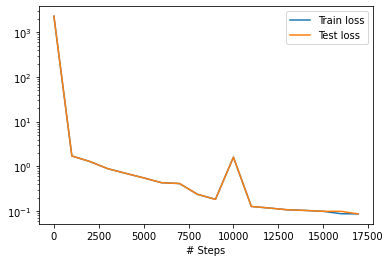

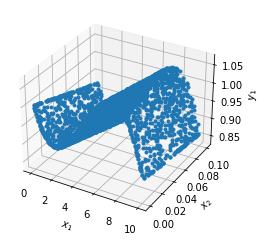

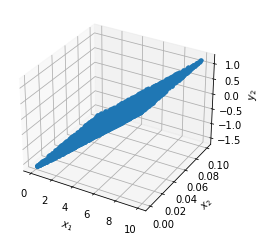

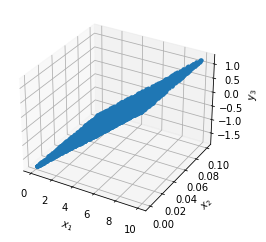

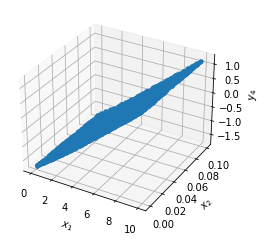

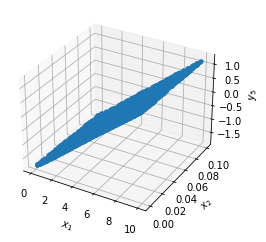

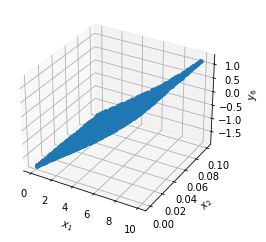

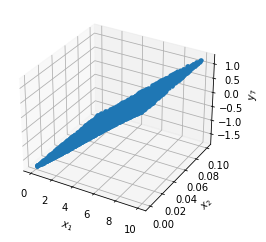

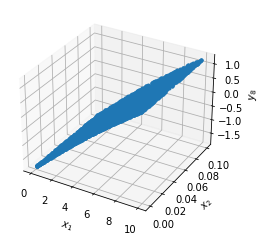

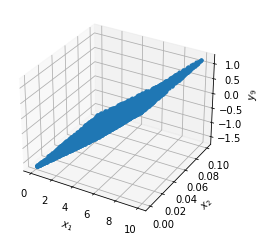

In [9]:
#Train the NN model
model.compile("adam", lr=1e-3)
model.train(epochs=15000)
model.compile("L-BFGS-B")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)